In [18]:
# https://www.kaggle.com/datasets/csafrit2/steel-industry-energy-consumption

In [19]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [20]:
df = pd.read_csv('Steel_industry_data.csv')
df

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.00,0.0,73.21,100.00,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.00,0.0,66.77,100.00,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.00,0.0,70.28,100.00,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.00,0.0,68.09,100.00,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.00,0.0,64.72,100.00,4500,Weekday,Monday,Light_Load
...,...,...,...,...,...,...,...,...,...,...,...
35035,31/12/2018 23:00,3.85,4.86,0.00,0.0,62.10,100.00,82800,Weekday,Monday,Light_Load
35036,31/12/2018 23:15,3.74,3.74,0.00,0.0,70.71,100.00,83700,Weekday,Monday,Light_Load
35037,31/12/2018 23:30,3.78,3.17,0.07,0.0,76.62,99.98,84600,Weekday,Monday,Light_Load
35038,31/12/2018 23:45,3.78,3.06,0.11,0.0,77.72,99.96,85500,Weekday,Monday,Light_Load


In [21]:
lbl_encoder = LabelEncoder()
df['WeekStatus'] = lbl_encoder.fit_transform(df['WeekStatus'])
df['Day_of_week'] = lbl_encoder.fit_transform(df['Day_of_week'])
df['Load_Type'] = lbl_encoder.fit_transform(df['Load_Type'])

In [22]:
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')

df['day'] = pd.to_datetime(df['date']).dt.day_of_year
df['month'] = pd.to_datetime(df['date']).dt.month

df['day'] = pd.to_numeric(df['day'])
df['month'] = pd.to_numeric(df['month'])

df = df.drop('date', axis=1)

df

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,day,month
0,3.17,2.95,0.00,0.0,73.21,100.00,900,0,1,0,1,1
1,4.00,4.46,0.00,0.0,66.77,100.00,1800,0,1,0,1,1
2,3.24,3.28,0.00,0.0,70.28,100.00,2700,0,1,0,1,1
3,3.31,3.56,0.00,0.0,68.09,100.00,3600,0,1,0,1,1
4,3.82,4.50,0.00,0.0,64.72,100.00,4500,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
35035,3.85,4.86,0.00,0.0,62.10,100.00,82800,0,1,0,365,12
35036,3.74,3.74,0.00,0.0,70.71,100.00,83700,0,1,0,365,12
35037,3.78,3.17,0.07,0.0,76.62,99.98,84600,0,1,0,365,12
35038,3.78,3.06,0.11,0.0,77.72,99.96,85500,0,1,0,365,12


In [23]:
df_train = df.sample(frac=0.8)
df_test = df.drop(df_train.index)

In [24]:
n = 1000
nu = 0.1
trees = []
PARAMS = ['Lagging_Current_Reactive.Power_kVarh','Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'WeekStatus', 'Day_of_week', 'Load_Type', 'day', 'month']
df_train['y_pred'] = df_train['Usage_kWh'].mean()

for i in range(n):
    df_train['r'] = df_train['Usage_kWh'] - df_train['y_pred']
    tree = DecisionTreeRegressor(max_depth=5)
    tree.fit(df_train[PARAMS], df_train['r'])
    df_train['y_pred'] += nu * tree.predict(df_train[PARAMS])
    trees.append(tree)
df_train

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,day,month,y_pred,r
24023,3.17,5.69,0.00,0.00,48.67,100.00,21600,1,2,0,251,9,3.148986,0.021043
25237,3.89,0.00,16.96,0.00,100.00,22.36,77400,0,4,2,263,9,3.862478,0.027550
32082,3.24,2.38,0.07,0.00,80.59,99.98,17100,1,2,0,335,12,3.305935,-0.065907
2064,13.64,3.24,18.58,0.01,97.29,59.18,44100,0,1,2,22,1,13.379594,0.260434
21114,2.70,4.39,0.00,0.00,52.39,100.00,81900,0,6,2,220,8,2.780153,-0.080124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,106.70,37.51,0.00,0.05,94.34,100.00,50400,0,4,2,11,1,107.162647,-0.463580
20125,34.92,3.13,0.11,0.02,99.60,100.00,55800,1,3,1,210,7,34.359350,0.560678
26426,3.06,6.44,0.00,0.00,42.92,100.00,24300,0,6,0,276,10,3.074023,-0.013995
13085,3.38,5.11,0.00,0.00,55.17,100.00,27000,0,4,0,137,5,3.384878,-0.004850


In [25]:
df_test['y_pred'] = df_test['Usage_kWh'].mean()
for tree in trees:
    df_test['y_pred'] += nu * tree.predict(df_test[PARAMS])
df_test['r'] = df_test['Usage_kWh'] - df_test['y_pred']
df_test

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,day,month,y_pred,r
0,3.17,2.95,0.00,0.0,73.21,100.00,900,0,1,0,1,1,3.878429,-0.708429
1,4.00,4.46,0.00,0.0,66.77,100.00,1800,0,1,0,1,1,4.310967,-0.310967
5,3.28,3.56,0.00,0.0,67.76,100.00,5400,0,1,0,1,1,3.688652,-0.408652
8,3.28,3.64,0.00,0.0,66.94,100.00,8100,0,1,0,1,1,3.598202,-0.318202
13,3.31,3.74,0.00,0.0,66.27,100.00,12600,0,1,0,1,1,3.642032,-0.332032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35005,4.07,0.00,20.23,0.0,100.00,19.72,55800,0,1,0,365,12,4.351755,-0.281755
35009,3.92,0.00,18.83,0.0,100.00,20.38,59400,0,1,0,365,12,4.390157,-0.470157
35021,4.14,0.00,20.05,0.0,100.00,20.22,70200,0,1,0,365,12,4.500373,-0.360373
35034,3.82,4.54,0.00,0.0,64.38,100.00,81900,0,1,0,365,12,4.245318,-0.425318


In [26]:
print(f'MAE train: {mean_absolute_error(df_train['Usage_kWh'], df_train['y_pred'])}')
print(f'MAE test: {mean_absolute_error(df_test['Usage_kWh'], df_test['y_pred'])}')

MAE train: 0.16600311146444974
MAE test: 0.5542001737875053


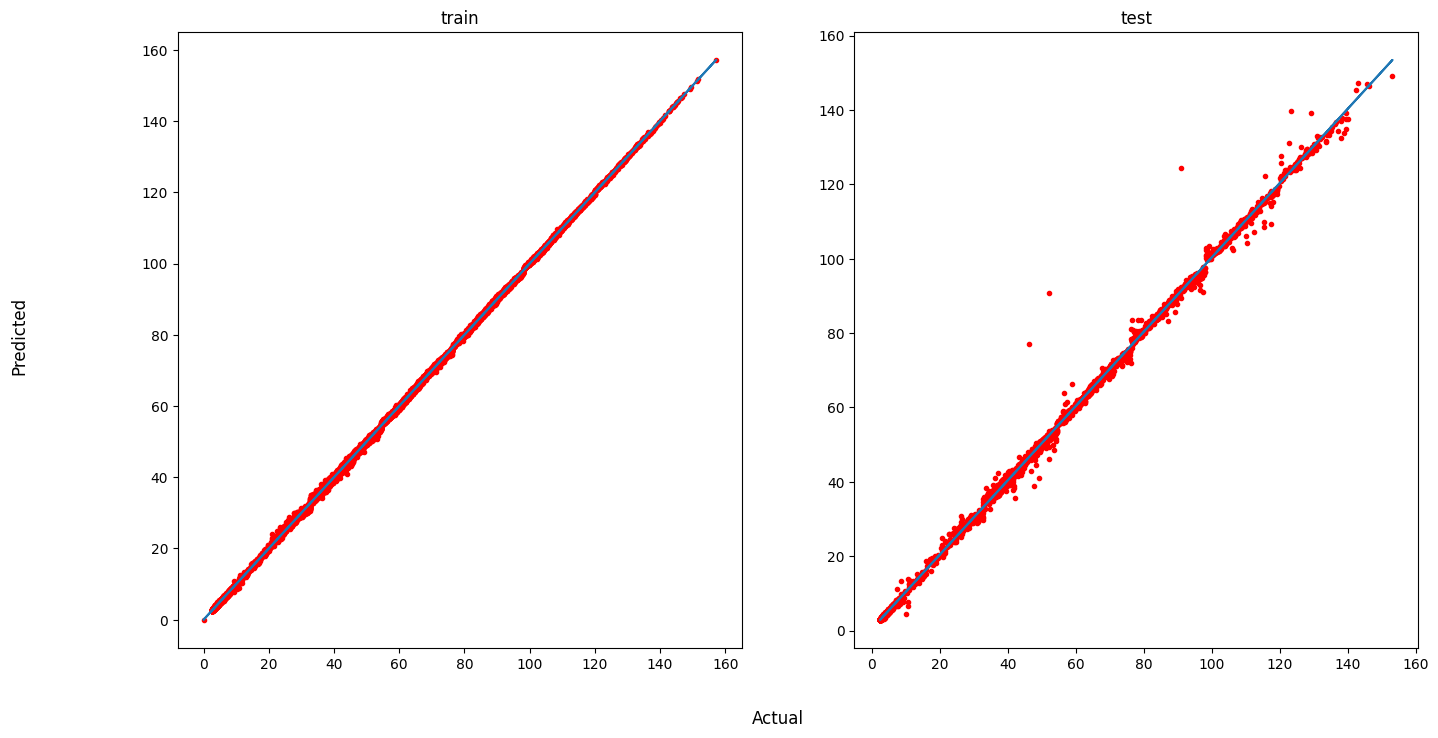

In [27]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16, 8)
fig.supxlabel('Actual')
fig.supylabel('Predicted')

x_train = df_train['Usage_kWh']
y_train = df_train['y_pred']

ax1.plot(x_train, y_train, '.', color = 'r')
m, b = np.polyfit(x_train, y_train, 1)
ax1.plot(x_train, m * x_train + b)
ax1.title.set_text('train')

x_test = df_test['Usage_kWh']
y_test = df_test['y_pred']

ax2.plot(x_test, y_test, '.', color = 'r')
m, b = np.polyfit(x_test, y_test, 1)
ax2.plot(x_test, m * x_test + b)
ax2.title.set_text('test')
